 # Análise Exploratória de Dado
------------------------------------------------------
Este notebook realiza a análise exploratória dos dados da camada Gold.

Python Version: 3.13.2
Database: SQLite (gold_layer.db)

# Importação de Bibliotecas

In [11]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

# Configuração de estilo dos gráficos

In [12]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
%matplotlib widget


# Conectar ao banco de dados da camada Gold

In [13]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
GOLD_DB_PATH = os.path.join(BASE_DIR, 'gold', 'gold_layer.db')

# Funções auxiliares para executar consultas SQL

In [14]:
def run_query(query, conn):
    """Executa uma consulta SQL e retorna os resultados como um DataFrame."""
    return pd.read_sql_query(query, conn)

def print_section(title):
    """Imprime um cabeçalho de seção com formatação."""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80 + "\n")

# Parte A: Volume de pedidos por mês e análise de sazonalidade

In [15]:
def run_query(query, conn):
    """Executa uma consulta SQL e retorna os resultados como um DataFrame."""
    return pd.read_sql_query(query, conn)

def print_section(title):
    """Imprime um cabeçalho de seção com formatação."""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80 + "\n")

# Parte A: Volume de pedidos por mês e análise de sazonalidade
def analise_volume_pedidos(conn):
    print_section("A) Volume de pedidos por mês e análise de sazonalidade")
    
    query = """
    SELECT 
        year, month, 
        num_orders, total_revenue,
        num_customers, avg_ticket
    FROM agg_sales_by_time
    ORDER BY year, month
    """
    
    vendas_mensais = run_query(query, conn)
    
    # Adicionar nomes dos meses
    vendas_mensais['mes_nome'] = vendas_mensais['month'].apply(lambda x: calendar.month_name[x])
    vendas_mensais['ano_mes'] = vendas_mensais.apply(lambda x: f"{x['year']}-{x['month']:02d}", axis=1)
    
    # Exibir os dados
    print("Volume de pedidos por mês:")
    print(vendas_mensais[['year', 'month', 'mes_nome', 'num_orders', 'total_revenue']])
    
    # Visualizar o volume de pedidos ao longo do tempo
    plt.figure(figsize=(16, 8))
    plt.plot(vendas_mensais['ano_mes'], vendas_mensais['num_orders'], marker='o', linewidth=2)
    plt.title('Volume de Pedidos por Mês', fontsize=18)
    plt.xlabel('Mês', fontsize=14)
    plt.ylabel('Número de Pedidos', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Visualizar a receita total ao longo do tempo
    plt.figure(figsize=(16, 8))
    plt.plot(vendas_mensais['ano_mes'], vendas_mensais['total_revenue'], marker='o', linewidth=2, color='green')
    plt.title('Receita Total por Mês', fontsize=18)
    plt.xlabel('Mês', fontsize=14)
    plt.ylabel('Receita Total (R$)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Analisar a sazonalidade agrupando por mês
    sazonalidade = vendas_mensais.groupby('month').agg({
        'num_orders': 'mean',
        'total_revenue': 'mean'
    }).reset_index()
    
    sazonalidade['mes_nome'] = sazonalidade['month'].apply(lambda x: calendar.month_name[x])
    sazonalidade = sazonalidade.sort_values('month')
    
    print("\nAnálise de sazonalidade (média mensal):")
    print(sazonalidade[['month', 'mes_nome', 'num_orders', 'total_revenue']])
    
    # Visualizar a sazonalidade
    plt.figure(figsize=(16, 8))
    plt.plot(sazonalidade['mes_nome'], sazonalidade['num_orders'], marker='o', linewidth=2)
    plt.title('Sazonalidade - Média de Pedidos por Mês', fontsize=18)
    plt.xlabel('Mês', fontsize=14)
    plt.ylabel('Média de Pedidos', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calcular o coeficiente de variação para determinar se há sazonalidade
    cv = sazonalidade['num_orders'].std() / sazonalidade['num_orders'].mean()
    meses_pico = sazonalidade.nlargest(3, 'num_orders')['mes_nome'].tolist()
    
    print(f"\nCoeficiente de variação dos pedidos mensais: {cv:.2f}")
    print(f"Meses de pico: {', '.join(meses_pico)}")
    
    conclusao = "Existe sazonalidade nas vendas" if cv > 0.1 else "Não existe sazonalidade significativa nas vendas"
    print(f"\nConclusão: {conclusao}")
    
    return vendas_mensais

# Parte B: Distribuição do tempo de entrega dos pedidos

In [16]:
def analise_tempo_entrega(conn):
    print_section("B) Distribuição do tempo de entrega dos pedidos")
    
    query = """
    SELECT 
        julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS tempo_entrega_dias,
        order_id
    FROM fact_sales
    WHERE order_delivered_customer_date IS NOT NULL
      AND order_purchase_timestamp IS NOT NULL
    GROUP BY order_id
    """
    
    tempo_entrega = run_query(query, conn)
    
    print("Estatísticas do tempo de entrega (em dias):")
    print(f"Média: {tempo_entrega['tempo_entrega_dias'].mean():.2f} dias")
    print(f"Mediana: {tempo_entrega['tempo_entrega_dias'].median():.2f} dias")
    print(f"Mínimo: {tempo_entrega['tempo_entrega_dias'].min():.2f} dias")
    print(f"Máximo: {tempo_entrega['tempo_entrega_dias'].max():.2f} dias")
    print(f"Desvio Padrão: {tempo_entrega['tempo_entrega_dias'].std():.2f} dias")
    
    
    percentuais = [10, 25, 50, 75, 90, 95, 99]
    for p in percentuais:
        print(f"Percentual {p}: {tempo_entrega['tempo_entrega_dias'].quantile(p/100):.2f} dias")
    
    plt.figure(figsize=(16, 8))
    sns.histplot(tempo_entrega['tempo_entrega_dias'], bins=50, kde=True)
    plt.title('Distribuição do Tempo de Entrega', fontsize=18)
    plt.xlabel('Tempo de Entrega (dias)', fontsize=14)
    plt.ylabel('Frequência', fontsize=14)
    plt.axvline(tempo_entrega['tempo_entrega_dias'].mean(), color='red', linestyle='--', 
                label=f'Média: {tempo_entrega["tempo_entrega_dias"].mean():.2f} dias')
    plt.axvline(tempo_entrega['tempo_entrega_dias'].median(), color='green', linestyle='--', 
                label=f'Mediana: {tempo_entrega["tempo_entrega_dias"].median():.2f} dias')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(16, 6))
    sns.boxplot(x=tempo_entrega['tempo_entrega_dias'])
    plt.title('Boxplot do Tempo de Entrega', fontsize=18)
    plt.xlabel('Tempo de Entrega (dias)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    bins = [0, 7, 14, 21, 30, float('inf')]
    labels = ['até 7 dias', '8-14 dias', '15-21 dias', '22-30 dias', 'mais de 30 dias']
    tempo_entrega['categoria'] = pd.cut(tempo_entrega['tempo_entrega_dias'], bins=bins, labels=labels)
    
    contagem_categorias = tempo_entrega['categoria'].value_counts().sort_index()
    
    print("\nDistribuição por categoria de tempo de entrega:")
    print(contagem_categorias)
    
    plt.figure(figsize=(16, 8))
    sns.countplot(y='categoria', data=tempo_entrega, order=labels)
    plt.title('Distribuição por Categoria de Tempo de Entrega', fontsize=18)
    plt.xlabel('Número de Pedidos', fontsize=14)
    plt.ylabel('Categoria', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return tempo_entrega

# Parte C: Relação entre o valor do frete e a distância de entrega

In [17]:
def analise_frete_distancia(conn):
    print_section("C) Relação entre o valor do frete e a distância de entrega")
    
    query = """
    SELECT 
        fs.order_id,
        fs.freight_value,
        c.customer_zip_code_prefix,
        c.customer_state,
        s.seller_zip_code_prefix,
        s.seller_state
    FROM fact_sales fs
    JOIN dim_customers c ON fs.customer_id = c.customer_id
    JOIN dim_sellers s ON fs.seller_id = s.seller_id
    """
    
    dados_frete = run_query(query, conn)
    
    dados_frete['mesmo_estado'] = dados_frete['customer_state'] == dados_frete['seller_state']
    
    frete_por_estado = dados_frete.groupby('mesmo_estado').agg({
        'freight_value': ['mean', 'median', 'std', 'count']
    }).reset_index()
    
    frete_por_estado.columns = ['mesmo_estado', 'frete_medio', 'frete_mediana', 'frete_std', 'quantidade']
    
    print("Relação entre frete e estado (mesmo estado vs. estados diferentes):")
    print(frete_por_estado)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='mesmo_estado', y='frete_medio', data=frete_por_estado)
    plt.title('Valor Médio do Frete por Relação de Estado', fontsize=18)
    plt.xlabel('Mesmo Estado', fontsize=14)
    plt.ylabel('Valor Médio do Frete (R$)', fontsize=14)
    plt.xticks([0, 1], ['Estados Diferentes', 'Mesmo Estado'])
    plt.tight_layout()
    plt.show()
    
    frete_por_estado_detalhado = dados_frete.groupby('customer_state').agg({
        'freight_value': ['mean', 'count']
    }).reset_index()
    
    frete_por_estado_detalhado.columns = ['estado_cliente', 'frete_medio', 'quantidade']
    frete_por_estado_detalhado = frete_por_estado_detalhado.sort_values('frete_medio', ascending=False)
    
    print("\nValor médio do frete por estado do cliente:")
    print(frete_por_estado_detalhado)
    
    plt.figure(figsize=(16, 10))
    sns.barplot(x='frete_medio', y='estado_cliente', data=frete_por_estado_detalhado)
    plt.title('Valor Médio do Frete por Estado do Cliente', fontsize=18)
    plt.xlabel('Valor Médio do Frete (R$)', fontsize=14)
    plt.ylabel('Estado do Cliente', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    query_preco = """
    SELECT 
        fs.order_id,
        fs.freight_value,
        fs.price,
        c.customer_state,
        s.seller_state
    FROM fact_sales fs
    JOIN dim_customers c ON fs.customer_id = c.customer_id
    JOIN dim_sellers s ON fs.seller_id = s.seller_id
    """
    
    dados_completos = run_query(query_preco, conn)
    dados_completos['mesmo_estado'] = dados_completos['customer_state'] == dados_completos['seller_state']
    dados_completos['percentual_frete'] = (dados_completos['freight_value'] / dados_completos['price']) * 100
    
    dados_filtrados = dados_completos[dados_completos['percentual_frete'] <= 100]
    
    plt.figure(figsize=(16, 8))
    plt.scatter(dados_filtrados['price'], dados_filtrados['freight_value'], alpha=0.1)
    plt.title('Relação entre Preço do Produto e Valor do Frete', fontsize=18)
    plt.xlabel('Preço do Produto (R$)', fontsize=14)
    plt.ylabel('Valor do Frete (R$)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(16, 8))
    sns.boxplot(x='mesmo_estado', y='percentual_frete', data=dados_filtrados)
    plt.title('Percentual do Frete em Relação ao Preço do Produto', fontsize=18)
    plt.xlabel('Mesmo Estado', fontsize=14)
    plt.ylabel('Percentual do Frete (%)', fontsize=14)
    plt.xticks([0, 1], ['Estados Diferentes', 'Mesmo Estado'])
    plt.tight_layout()
    plt.show()
    
    return dados_frete

# Parte D: Categorias de produtos mais vendidas em termos de faturamento

In [18]:
def analise_categorias_produtos(conn):
    print_section("D) Categorias de produtos mais vendidas em termos de faturamento")
    
    query = """
    SELECT 
        category,
        total_revenue,
        num_orders,
        avg_ticket
    FROM agg_sales_by_category
    ORDER BY total_revenue DESC
    """
    
    categorias = run_query(query, conn)
    
    print("Top 20 categorias de produtos por faturamento:")
    print(categorias.head(20))
    
    plt.figure(figsize=(16, 10))
    sns.barplot(x='total_revenue', y='category', data=categorias.head(10), palette='viridis')
    plt.title('Top 10 Categorias de Produtos por Faturamento', fontsize=18)
    plt.xlabel('Faturamento Total (R$)', fontsize=14)
    plt.ylabel('Categoria', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    top10 = categorias.head(10).copy()
    plt.figure(figsize=(16, 10))
    sns.barplot(x='num_orders', y='category', data=top10, palette='viridis')
    plt.title('Número de Pedidos por Categoria (Top 10 em Faturamento)', fontsize=18)
    plt.xlabel('Número de Pedidos', fontsize=14)
    plt.ylabel('Categoria', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(16, 10))
    sns.barplot(x='avg_ticket', y='category', data=top10, palette='viridis')
    plt.title('Ticket Médio por Categoria (Top 10 em Faturamento)', fontsize=18)
    plt.xlabel('Ticket Médio (R$)', fontsize=14)
    plt.ylabel('Categoria', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    total_faturamento = categorias['total_revenue'].sum()
    categorias['percentual_faturamento'] = (categorias['total_revenue'] / total_faturamento) * 100
    
    print("\nDistribuição percentual do faturamento por categoria:")
    print(categorias[['category', 'total_revenue', 'percentual_faturamento']].head(20))
    
    categorias_sorted = categorias.sort_values('total_revenue', ascending=False).copy()
    categorias_sorted['percentual_acumulado'] = categorias_sorted['percentual_faturamento'].cumsum()
    
    print("\nAnálise de Pareto (percentual acumulado do faturamento):")
    print(categorias_sorted[['category', 'percentual_faturamento', 'percentual_acumulado']].head(20))
    
    plt.figure(figsize=(16, 8))
    plt.bar(range(len(categorias_sorted)), categorias_sorted['percentual_faturamento'], color='skyblue')
    plt.plot(range(len(categorias_sorted)), categorias_sorted['percentual_acumulado'], color='red', marker='o')
    plt.title('Análise de Pareto - Faturamento por Categoria', fontsize=18)
    plt.xlabel('Categorias (ordenadas por faturamento)', fontsize=14)
    plt.ylabel('Percentual do Faturamento (%)', fontsize=14)
    plt.axhline(y=80, color='green', linestyle='--', label='Limite de 80%')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    n_categorias_80 = (categorias_sorted['percentual_acumulado'] <= 80).sum()
    print(f"\nNúmero de categorias que representam 80% do faturamento: {n_categorias_80}")
    print(f"Total de categorias: {len(categorias_sorted)}")
    print(f"Percentual de categorias que representam 80% do faturamento: {(n_categorias_80/len(categorias_sorted))*100:.2f}%")
    
    return categorias

# Parte E: Estados brasileiros com maior valor médio de pedido

In [19]:
def analise_estados_valor_pedido(conn):
    print_section("E) Estados brasileiros com maior valor médio de pedido")
    
    query = """
    SELECT 
        c.customer_state as estado,
        COUNT(DISTINCT fs.order_id) as num_pedidos,
        SUM(fs.price) as faturamento_total,
        SUM(fs.price) / COUNT(DISTINCT fs.order_id) as valor_medio_pedido
    FROM fact_sales fs
    JOIN dim_customers c ON fs.customer_id = c.customer_id
    GROUP BY c.customer_state
    ORDER BY valor_medio_pedido DESC
    """
    
    estados = run_query(query, conn)
    
    print("Valor médio de pedido por estado brasileiro:")
    print(estados)
    
    plt.figure(figsize=(16, 10))
    sns.barplot(x='valor_medio_pedido', y='estado', data=estados, palette='viridis')
    plt.title('Valor Médio de Pedido por Estado', fontsize=18)
    plt.xlabel('Valor Médio de Pedido (R$)', fontsize=14)
    plt.ylabel('Estado', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(16, 10))
    sns.barplot(x='faturamento_total', y='estado', data=estados.sort_values('faturamento_total', ascending=False), 
               palette='viridis')
    plt.title('Faturamento Total por Estado', fontsize=18)
    plt.xlabel('Faturamento Total (R$)', fontsize=14)
    plt.ylabel('Estado', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(16, 10))
    sns.barplot(x='num_pedidos', y='estado', data=estados.sort_values('num_pedidos', ascending=False), 
               palette='viridis')
    plt.title('Número de Pedidos por Estado', fontsize=18)
    plt.xlabel('Número de Pedidos', fontsize=14)
    plt.ylabel('Estado', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(16, 10))
    plt.scatter(estados['num_pedidos'], estados['valor_medio_pedido'], s=100, alpha=0.7)
    
    for i, row in estados.iterrows():
        plt.annotate(row['estado'], (row['num_pedidos'], row['valor_medio_pedido']), 
                     fontsize=12, ha='center')
    
    plt.title('Relação entre Número de Pedidos e Valor Médio por Estado', fontsize=18)
    plt.xlabel('Número de Pedidos', fontsize=14)
    plt.ylabel('Valor Médio de Pedido (R$)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return estados


============ ANÁLISE EXPLORATÓRIA DE DADOS - E-COMMERCE BRASILEIRO =============


============ A) Volume de pedidos por mês e análise de sazonalidade ============

Volume de pedidos por mês:
    year  month   mes_nome  num_orders  total_revenue
0   2016      9  September           3         267.36
1   2016     10    October         308       50942.23
2   2016     12   December           1          10.90
3   2017      1    January         789      128637.99
4   2017      2   February        1733      260753.86
5   2017      3      March        2641      396451.04
6   2017      4      April        2391      391784.42
7   2017      5        May        3660      545340.65
8   2017      6       June        3217      453031.41
9   2017      7       July        3969      533616.84
10  2017      8     August        4293      601409.67
11  2017      9  September        4243      662276.39
12  2017     10    October        4568      693807.60
13  2017     11   November        7451     1046127.

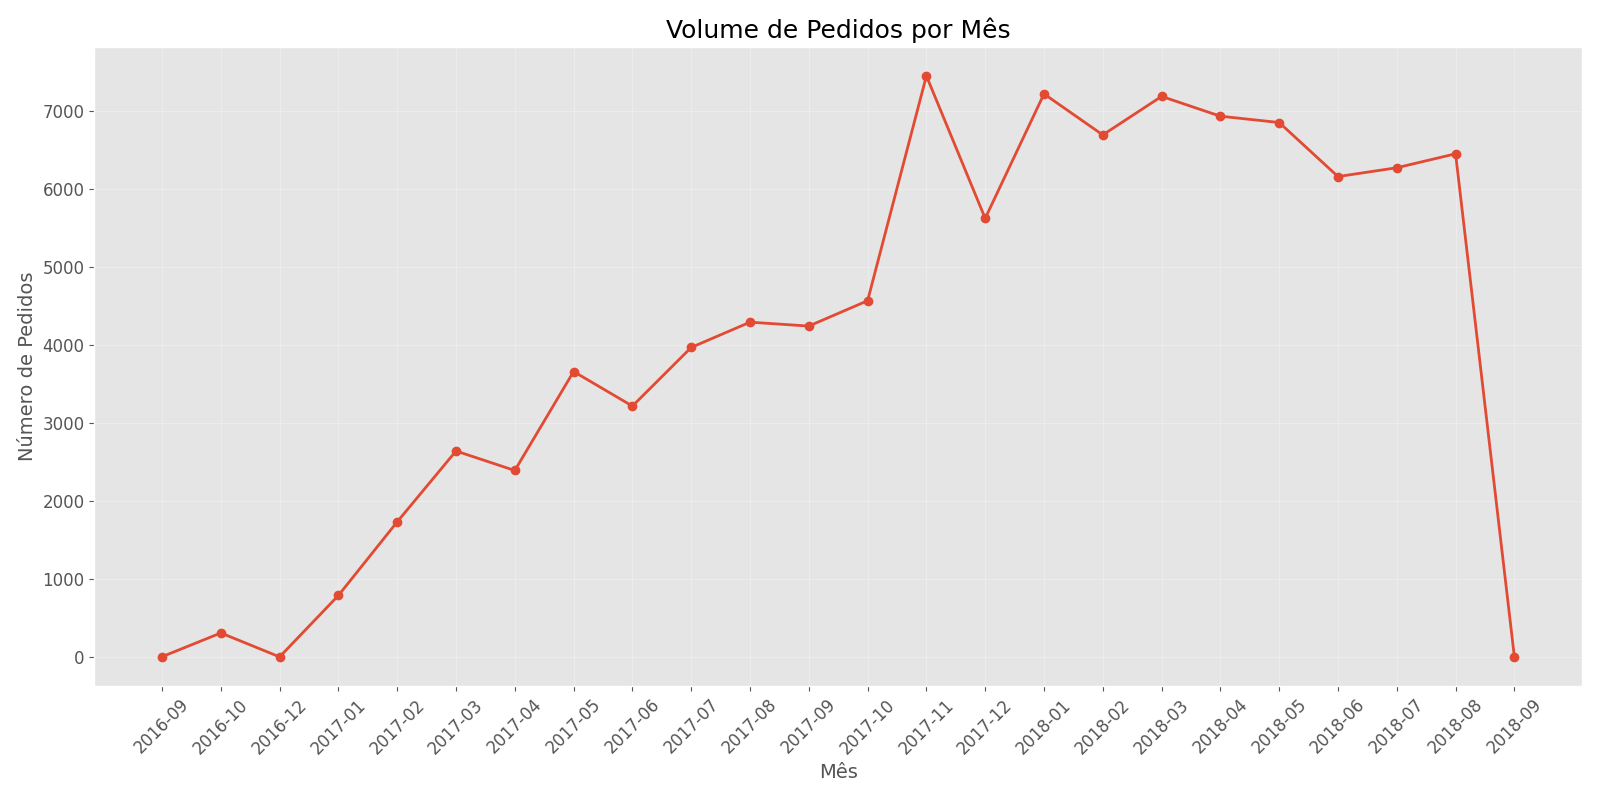

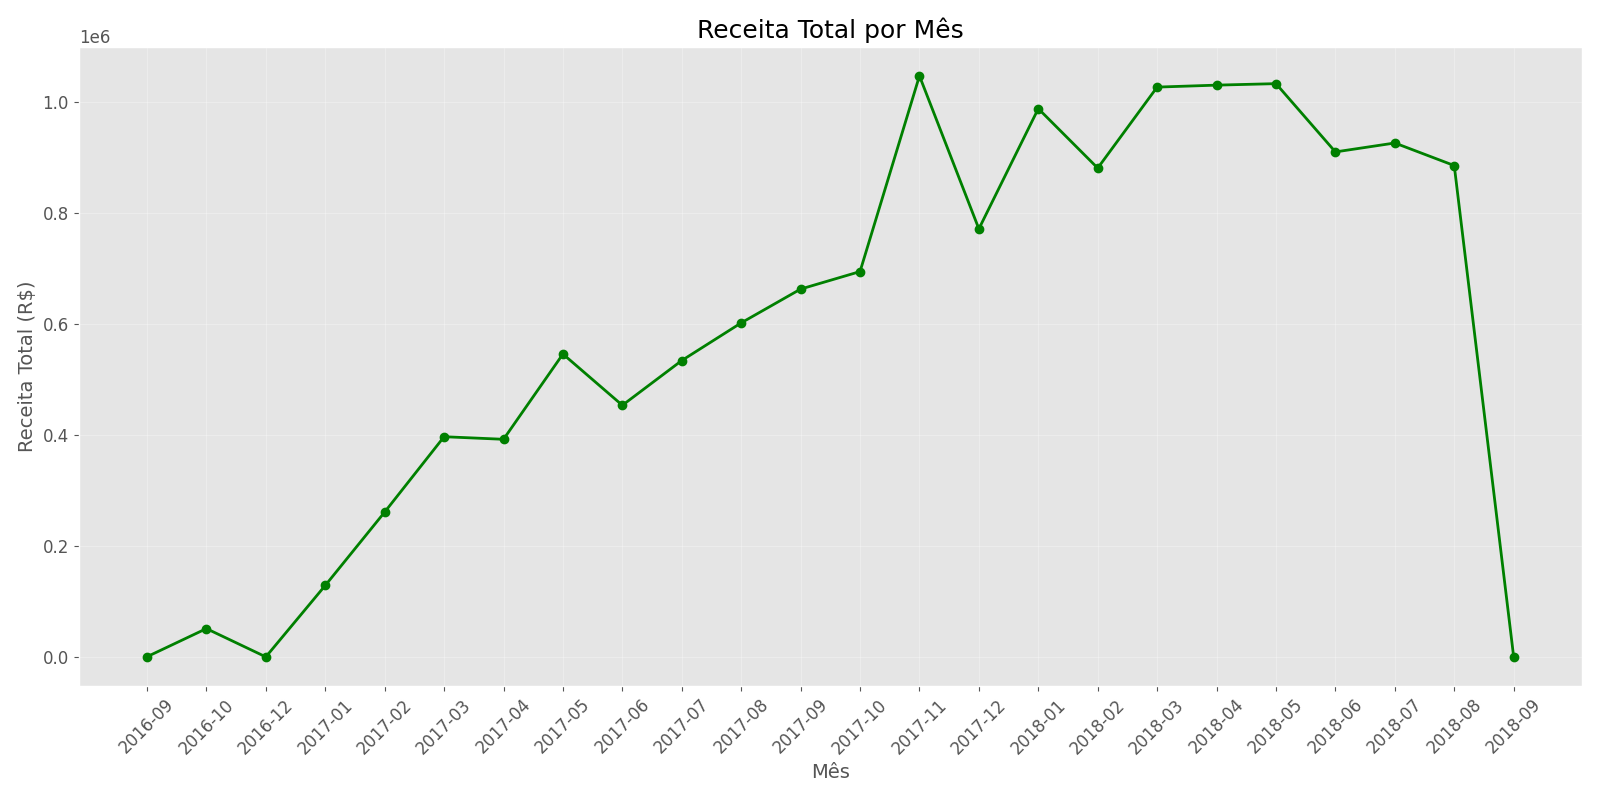


Análise de sazonalidade (média mensal):
    month   mes_nome   num_orders  total_revenue
0       1    January  4004.500000     557894.700
1       2   February  4213.500000     570426.825
2       3      March  4914.500000     711193.550
3       4      April  4662.500000     710628.360
4       5        May  5256.500000     788745.545
5       6       June  4688.500000     681126.255
6       7       July  5121.000000     729459.650
7       8     August  5372.500000     743033.535
8       9  September  1415.666667     220896.250
9      10    October  2438.000000     372374.915
10     11   November  7451.000000    1046127.840
11     12   December  2812.500000     385333.525


C:\Users\Renan Oliveira\AppData\Local\Temp\ipykernel_15376\953035915.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 8))


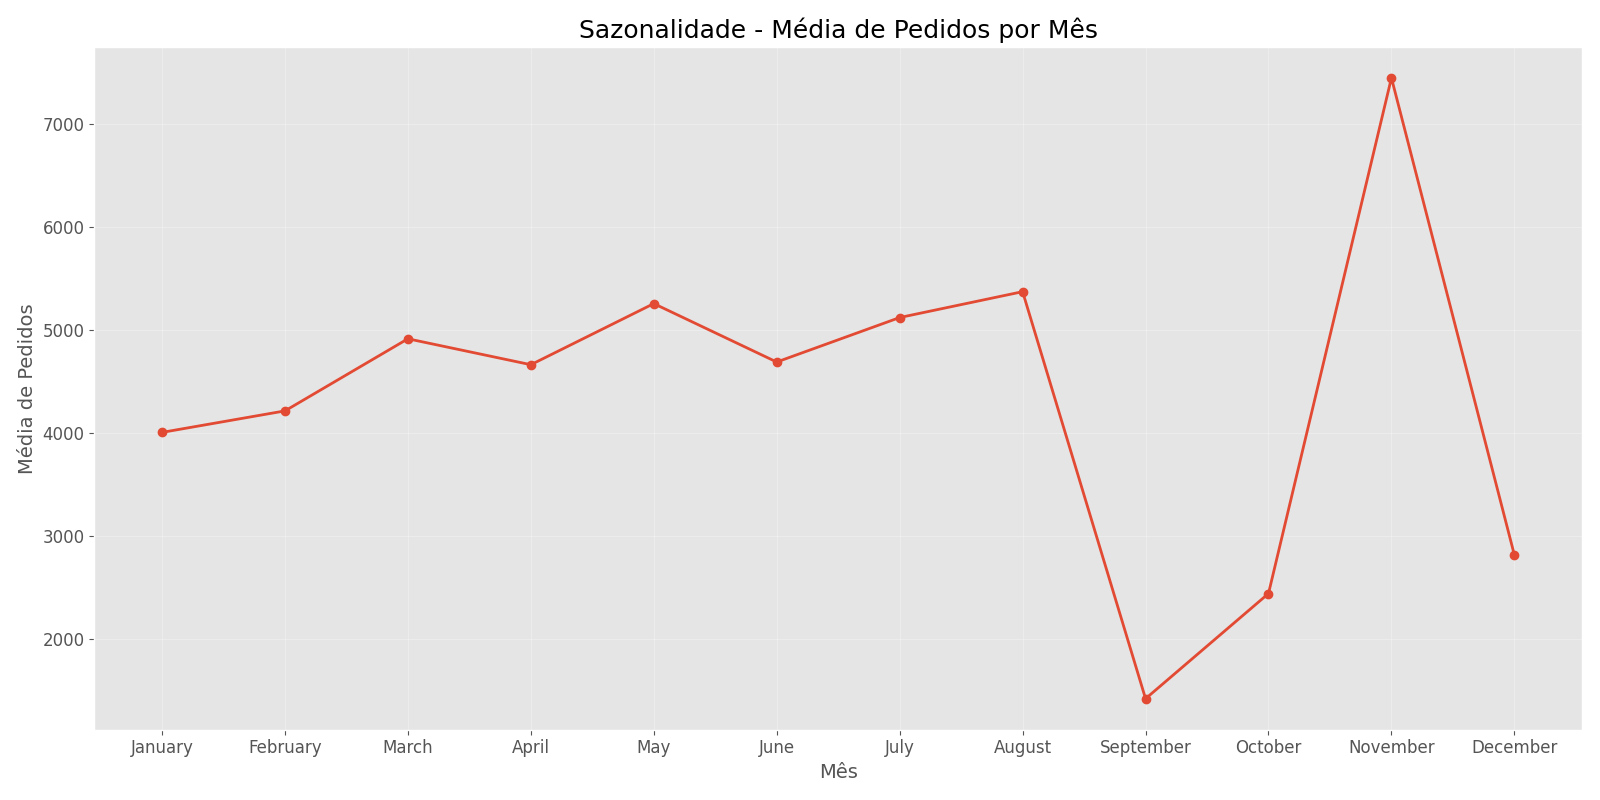


Coeficiente de variação dos pedidos mensais: 0.36
Meses de pico: November, August, May

Conclusão: Existe sazonalidade nas vendas

=============== B) Distribuição do tempo de entrega dos pedidos ================

Estatísticas do tempo de entrega (em dias):
Média: 12.56 dias
Mediana: 10.22 dias
Mínimo: 0.53 dias
Máximo: 209.63 dias
Desvio Padrão: 9.55 dias
Percentual 10: 4.16 dias
Percentual 25: 6.77 dias
Percentual 50: 10.22 dias
Percentual 75: 15.72 dias
Percentual 90: 23.10 dias
Percentual 95: 29.28 dias
Percentual 99: 46.05 dias


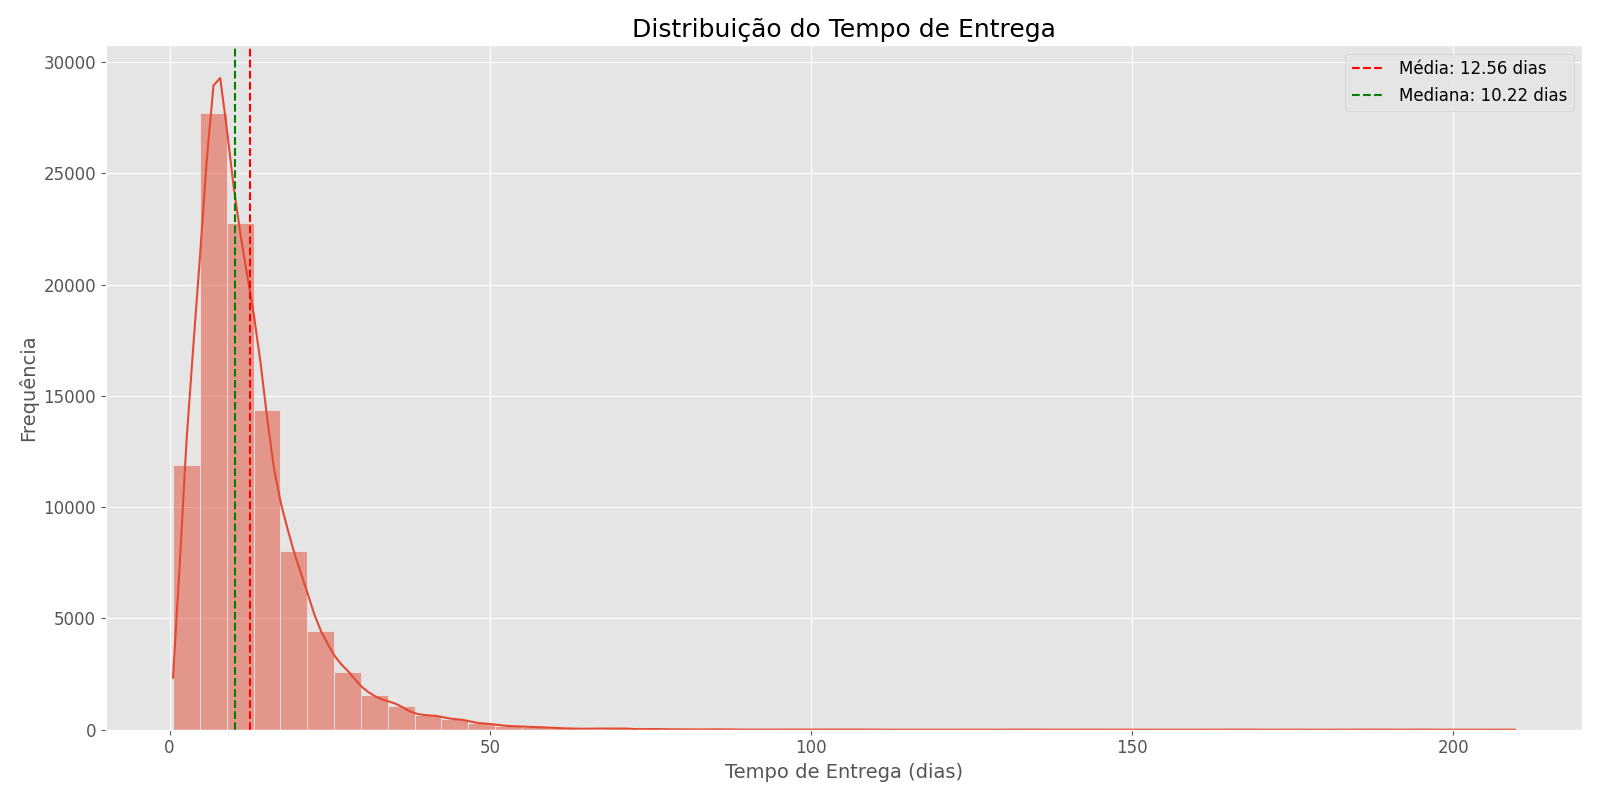

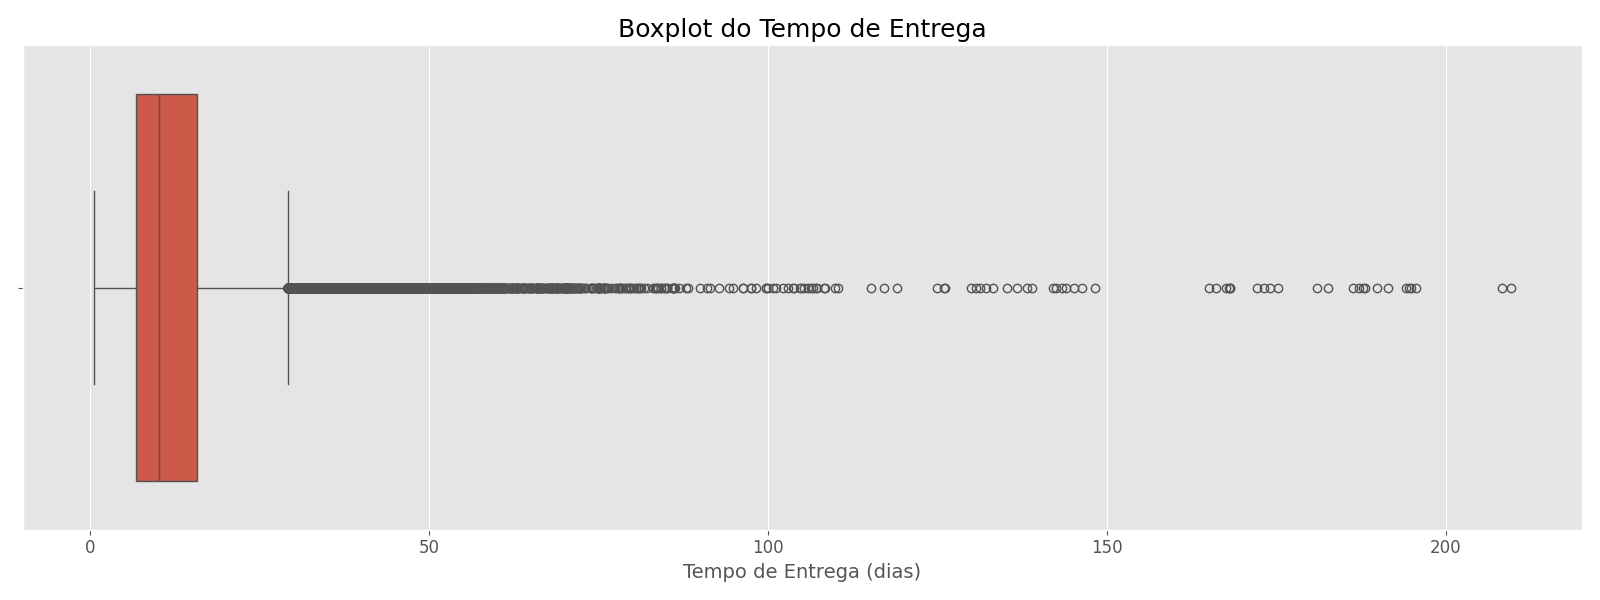


Distribuição por categoria de tempo de entrega:
categoria
até 7 dias         26046
8-14 dias          40215
15-21 dias         17713
22-30 dias          7949
mais de 30 dias     4553
Name: count, dtype: int64


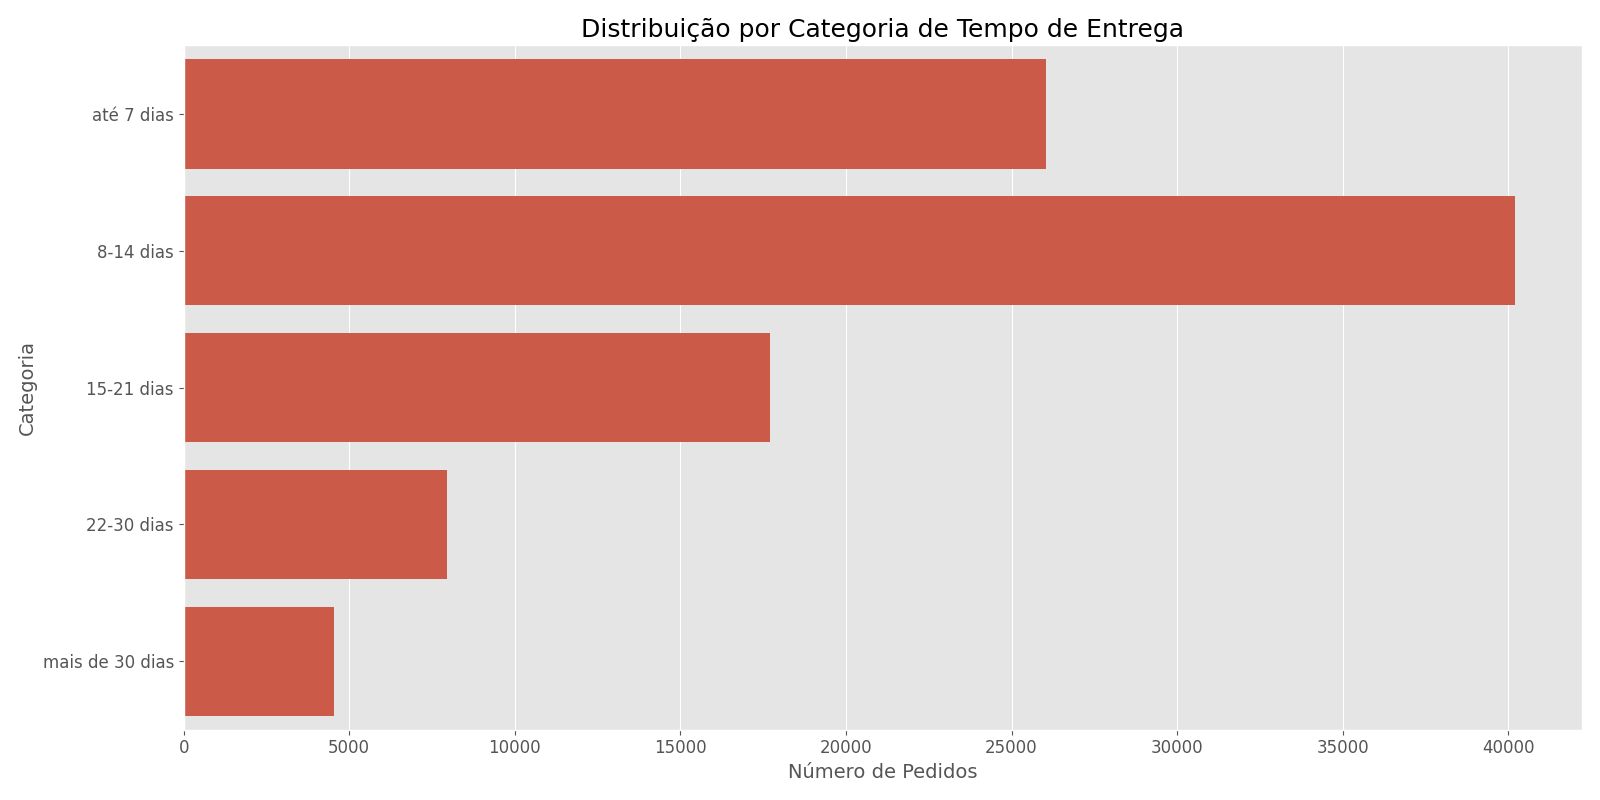


========== C) Relação entre o valor do frete e a distância de entrega ==========

Relação entre frete e estado (mesmo estado vs. estados diferentes):
   mesmo_estado  frete_medio  frete_mediana  frete_std  quantidade
0         False    23.758200          18.26  17.729875       75146
1          True    13.474571          11.99   8.539507       42458


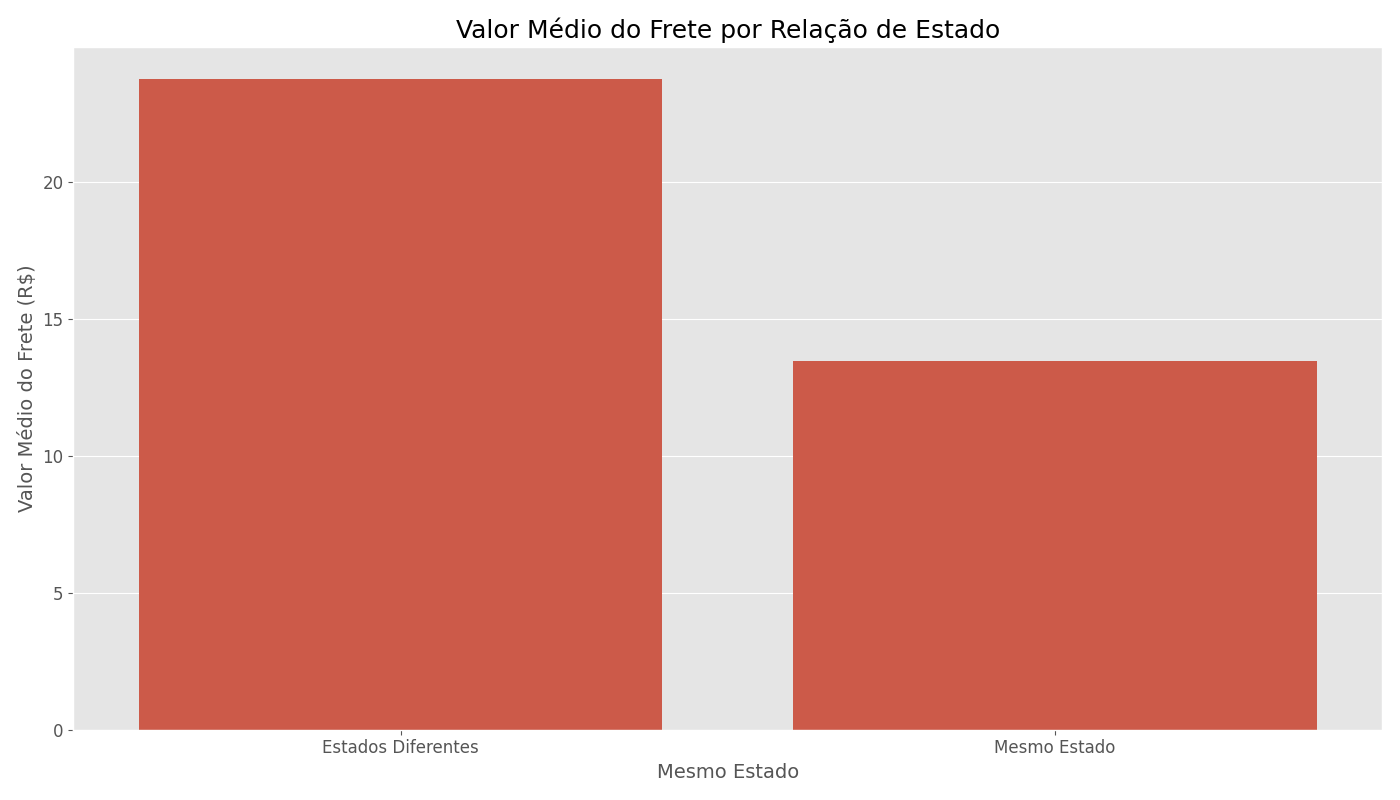


Valor médio do frete por estado do cliente:
   estado_cliente  frete_medio  quantidade
14             pb    43.257778         639
21             rr    42.984423          52
20             ro    40.970175         286
0              ac    40.021684          95
26             to    39.677286         339
16             pi    39.233229         573
9              ma    38.258685         844
24             se    36.627935         397
1              al    35.739410         458
13             pa    35.735708        1116
19             rn    35.279930         569
3              ap    34.084405          84
2              am    33.079181         171
15             pe    32.781133        1889
5              ce    32.463275        1551
12             mt    28.970951        1125
4              ba    26.318829        4048
11             ms    23.415706         843
8              go    22.731494        2430
7              es    21.981424        2338
22             rs    21.828506        6486
23       

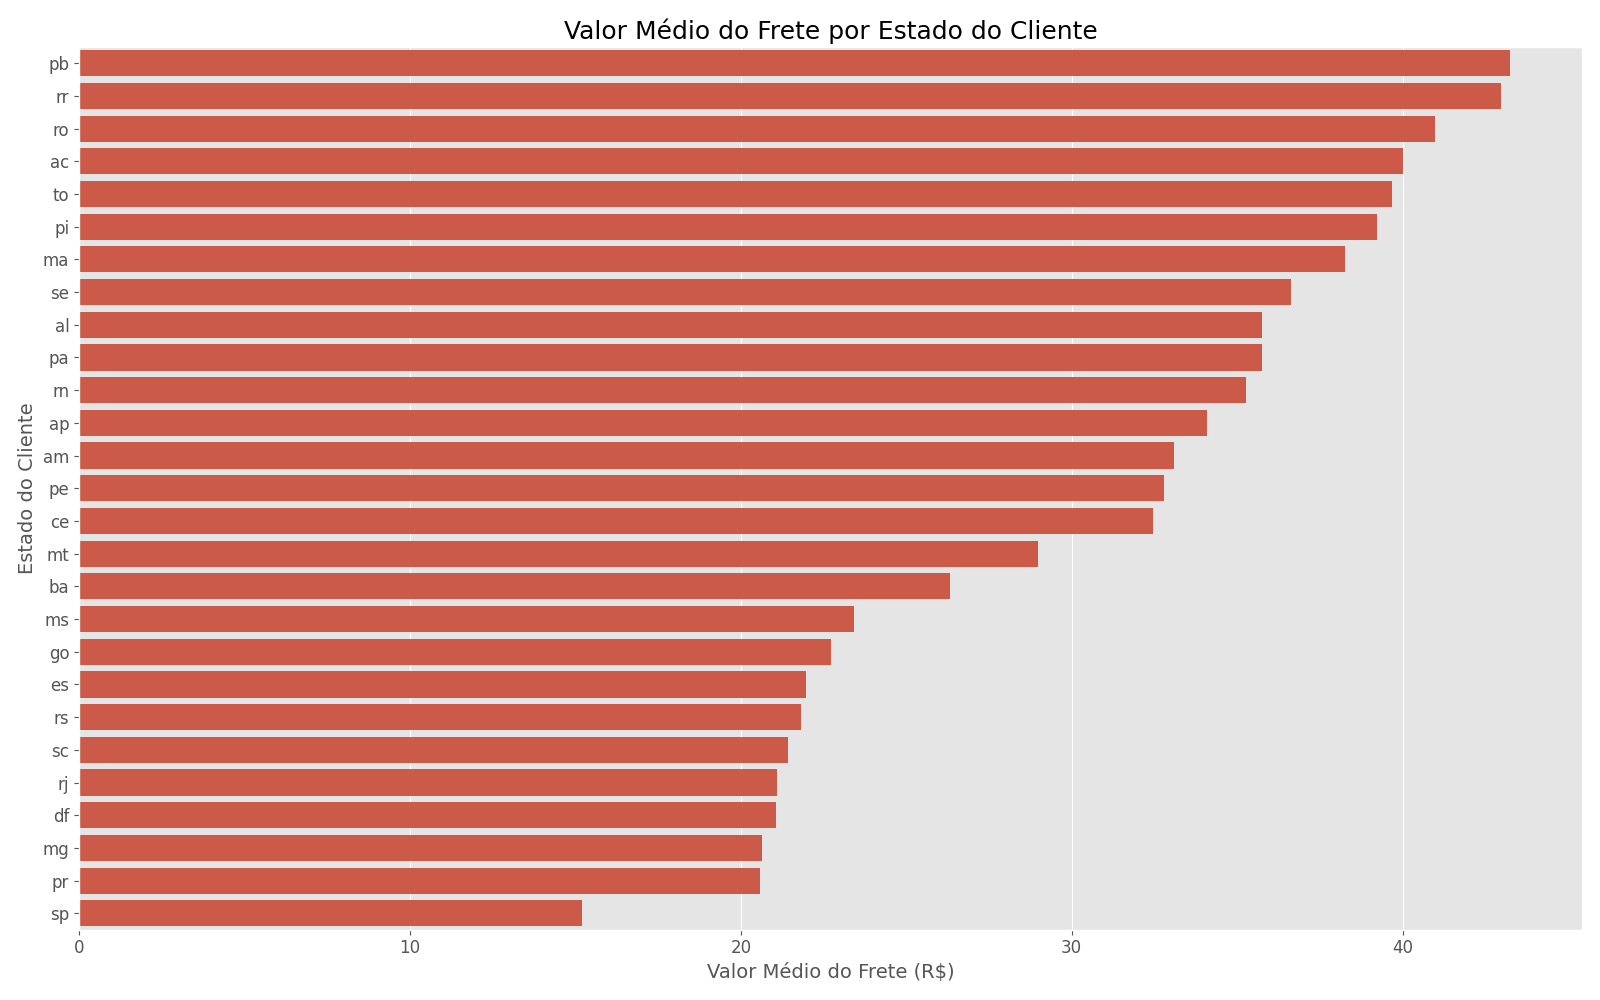

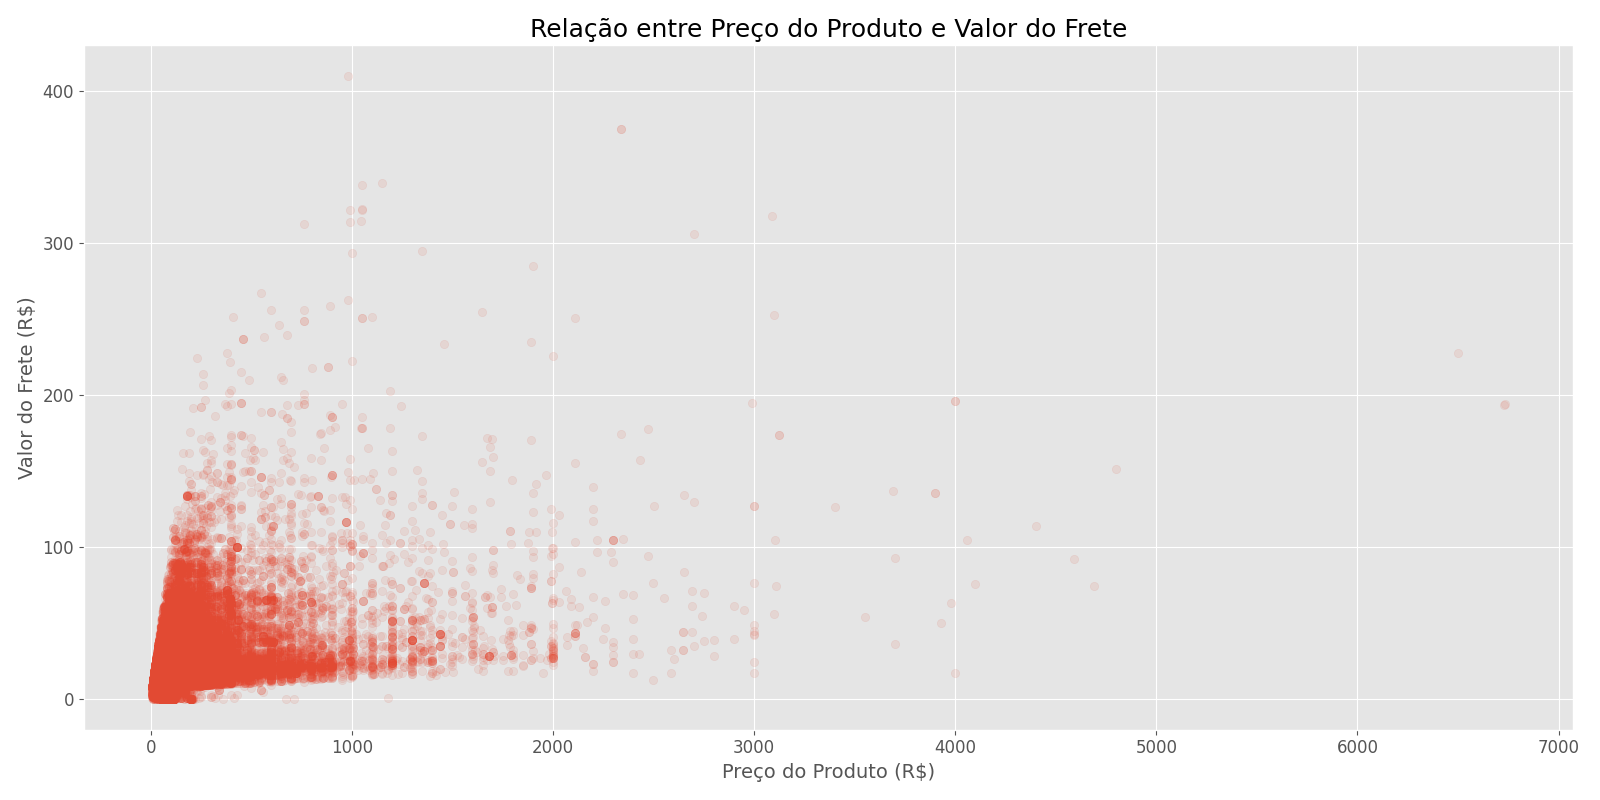

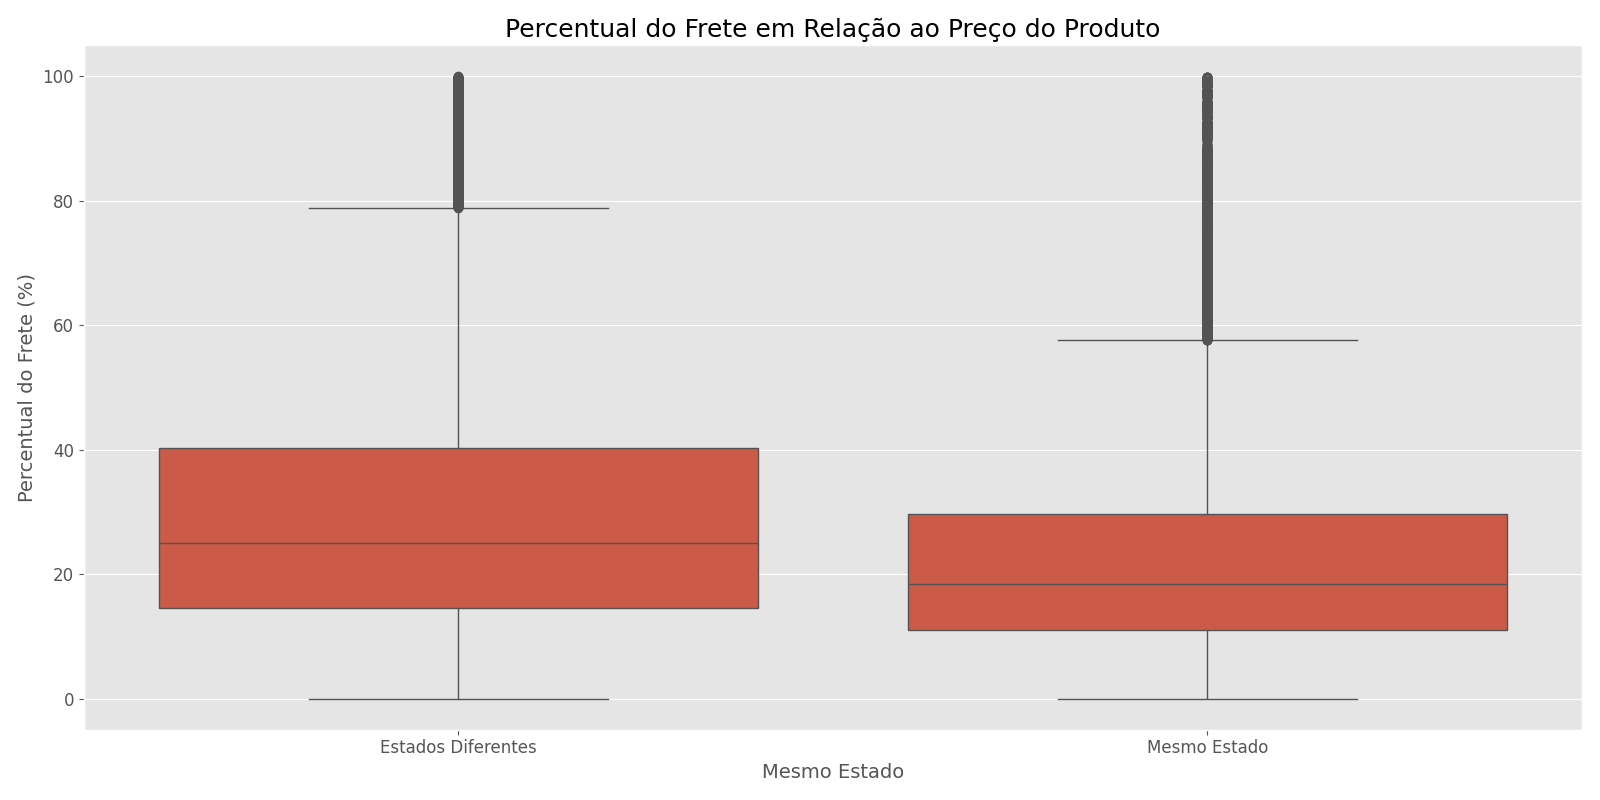


======= D) Categorias de produtos mais vendidas em termos de faturamento =======

Top 20 categorias de produtos por faturamento:
                 category  total_revenue  num_orders   avg_ticket
0           health_beauty     1297490.77        9975   130.074263
1           watches_gifts     1253143.30        6201   202.087292
2          bed_bath_table     1092551.02       11823    92.408950
3          sports_leisure     1023996.34        8945   114.476952
4   computers_accessories      942277.57        8082   116.589652
5         furniture_decor      765093.89        8744    87.499301
6              housewares      666587.00        7355    90.630455
7              cool_stuff      662309.49        3987   166.117254
8                    auto      616752.51        4379   140.843231
9            garden_tools      518217.54        4574   113.296358
10                   toys      500295.09        4273   117.082867
11                   baby      434479.61        3196   135.944809
12          

C:\Users\Renan Oliveira\AppData\Local\Temp\ipykernel_15376\2447483942.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_revenue', y='category', data=categorias.head(10), palette='viridis')


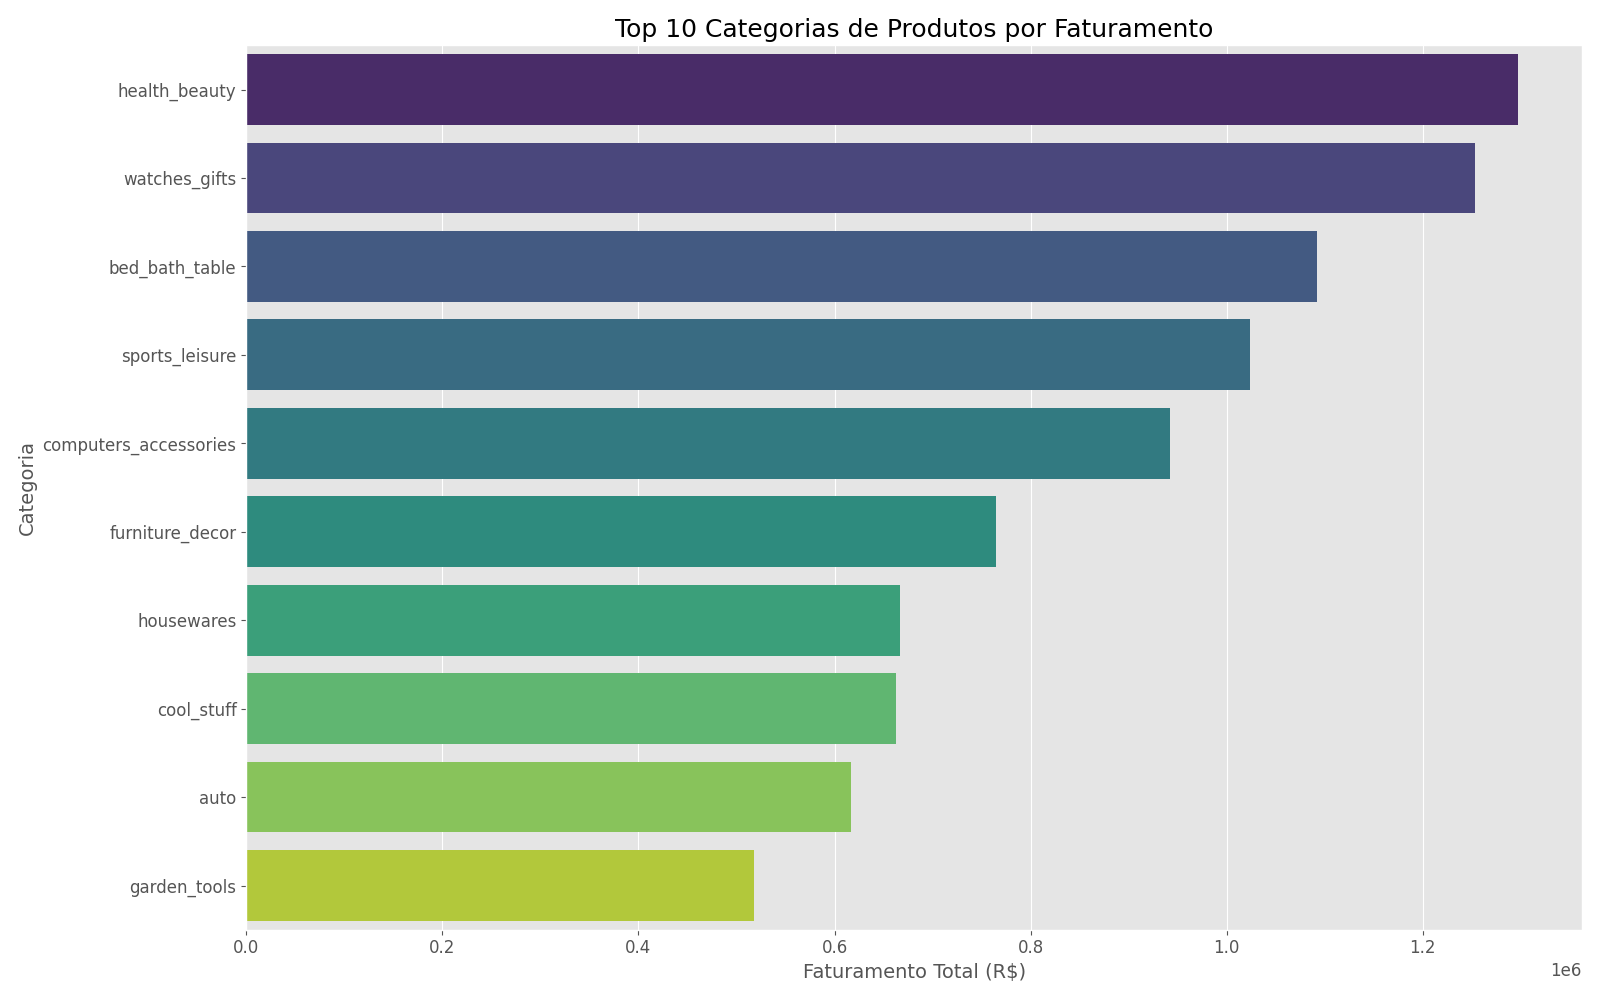

C:\Users\Renan Oliveira\AppData\Local\Temp\ipykernel_15376\2447483942.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_orders', y='category', data=top10, palette='viridis')


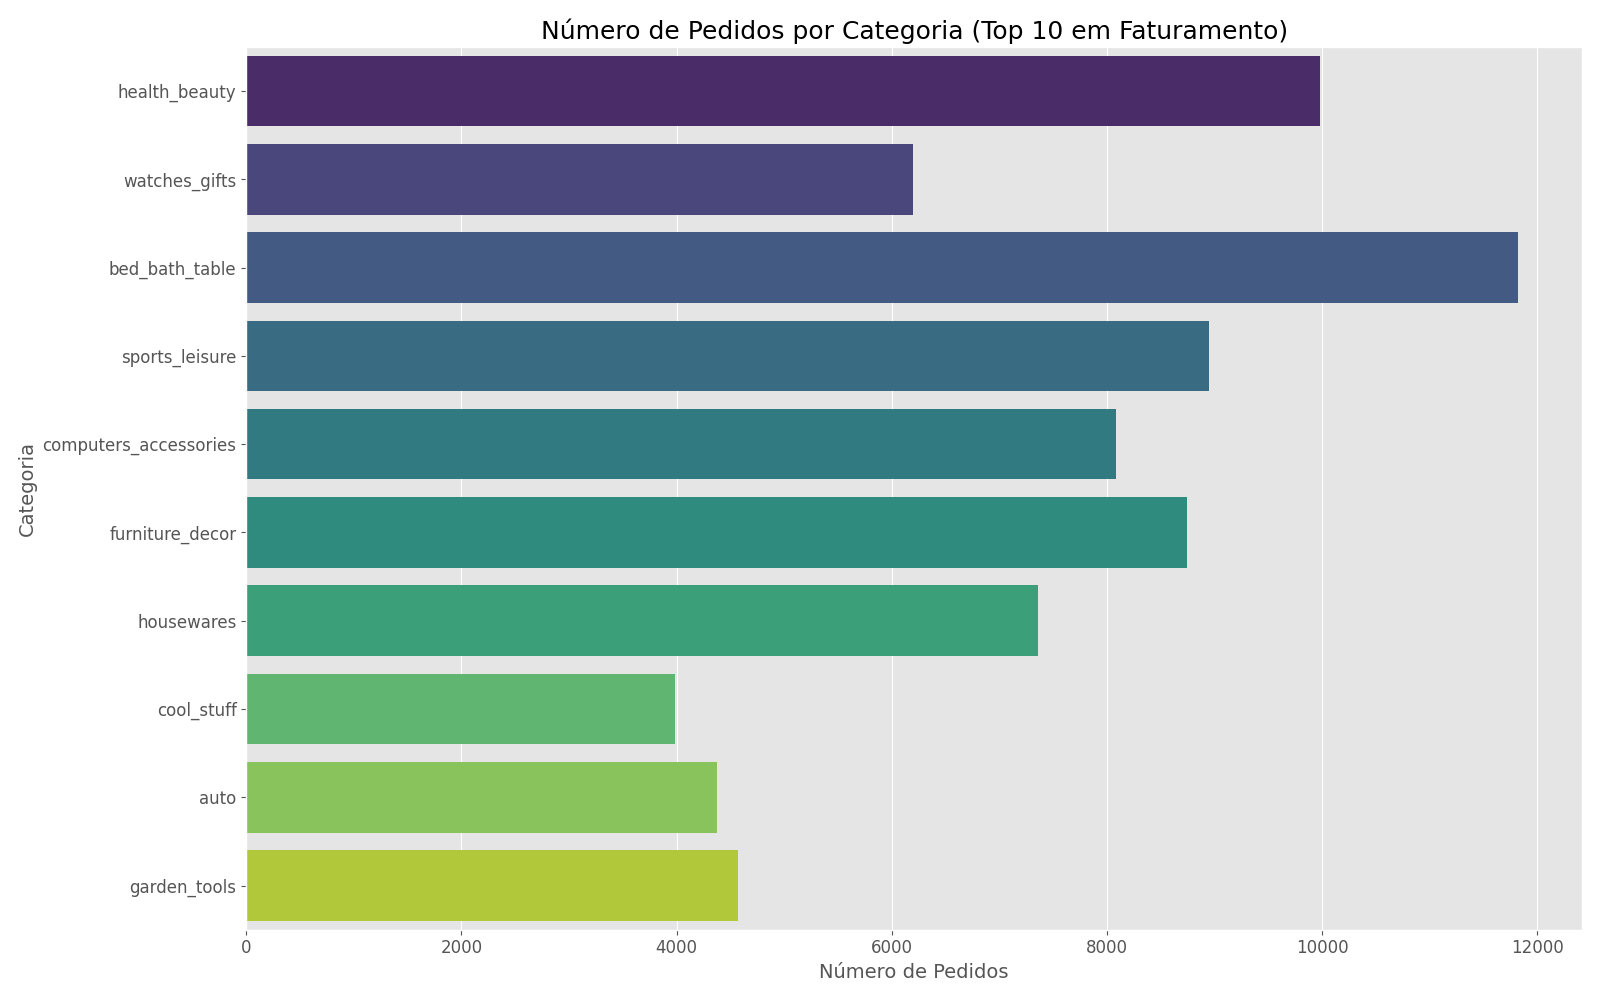

C:\Users\Renan Oliveira\AppData\Local\Temp\ipykernel_15376\2447483942.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_ticket', y='category', data=top10, palette='viridis')


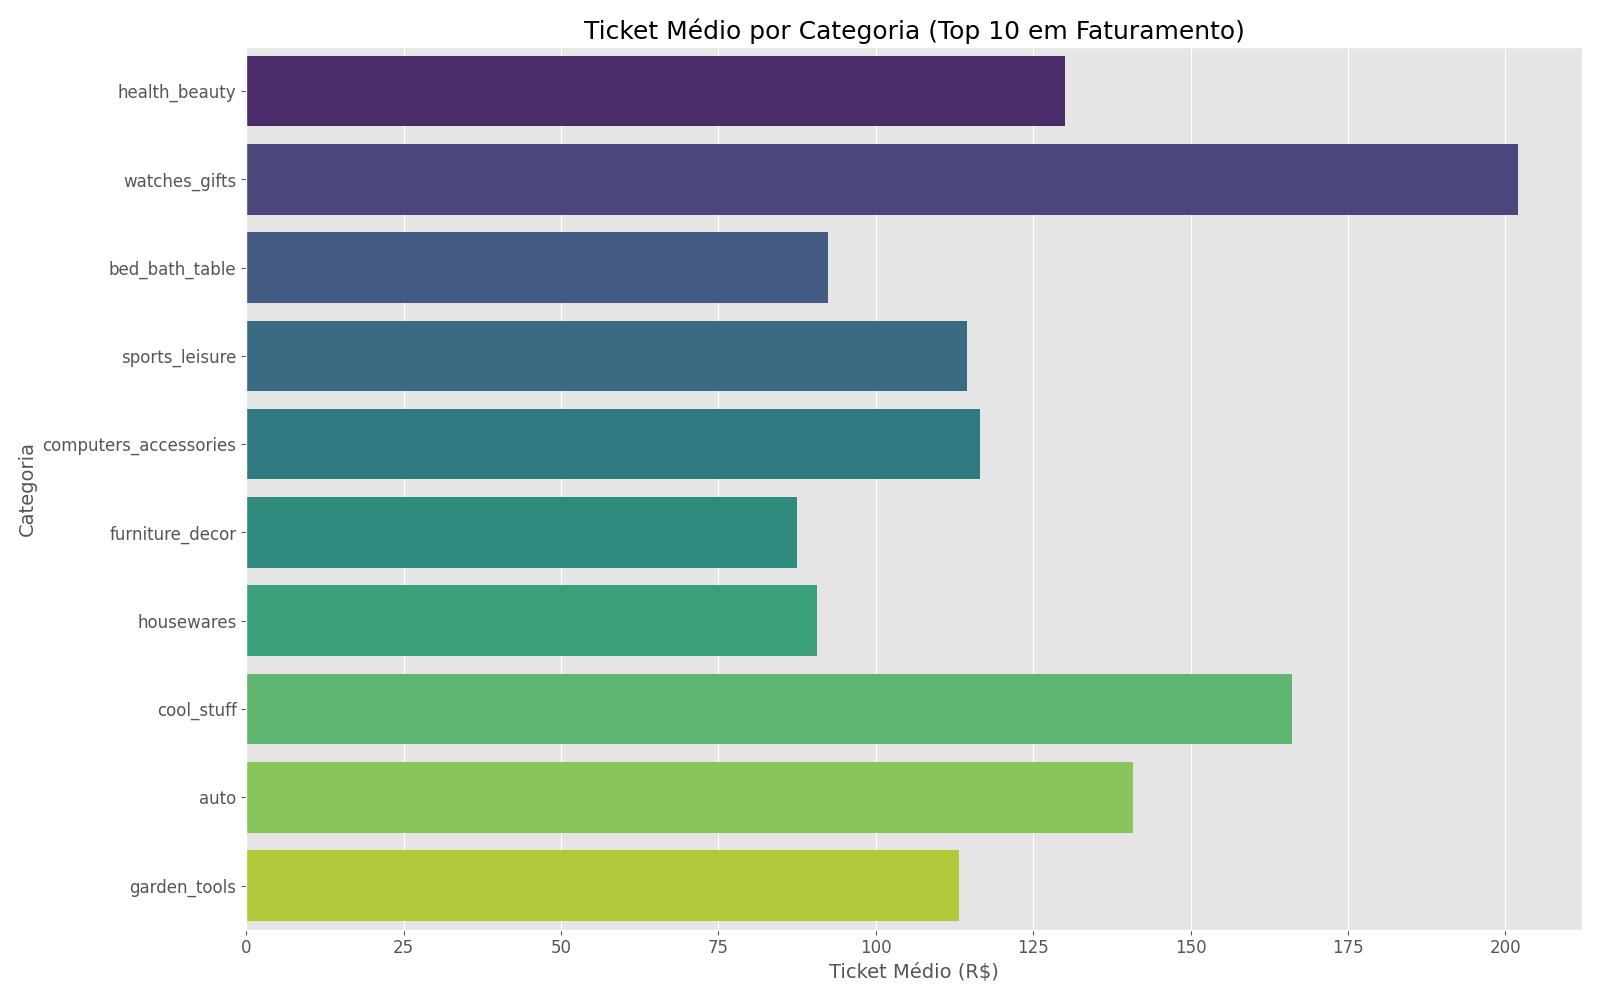


Distribuição percentual do faturamento por categoria:
                 category  total_revenue  percentual_faturamento
0           health_beauty     1297490.77                9.131311
1           watches_gifts     1253143.30                8.819208
2          bed_bath_table     1092551.02                7.689012
3          sports_leisure     1023996.34                7.206547
4   computers_accessories      942277.57                6.631438
5         furniture_decor      765093.89                5.384478
6              housewares      666587.00                4.691219
7              cool_stuff      662309.49                4.661115
8                    auto      616752.51                4.340500
9            garden_tools      518217.54                3.647044
10                   toys      500295.09                3.520911
11                   baby      434479.61                3.057724
12              perfumery      412754.81                2.904832
13              telephony      3393

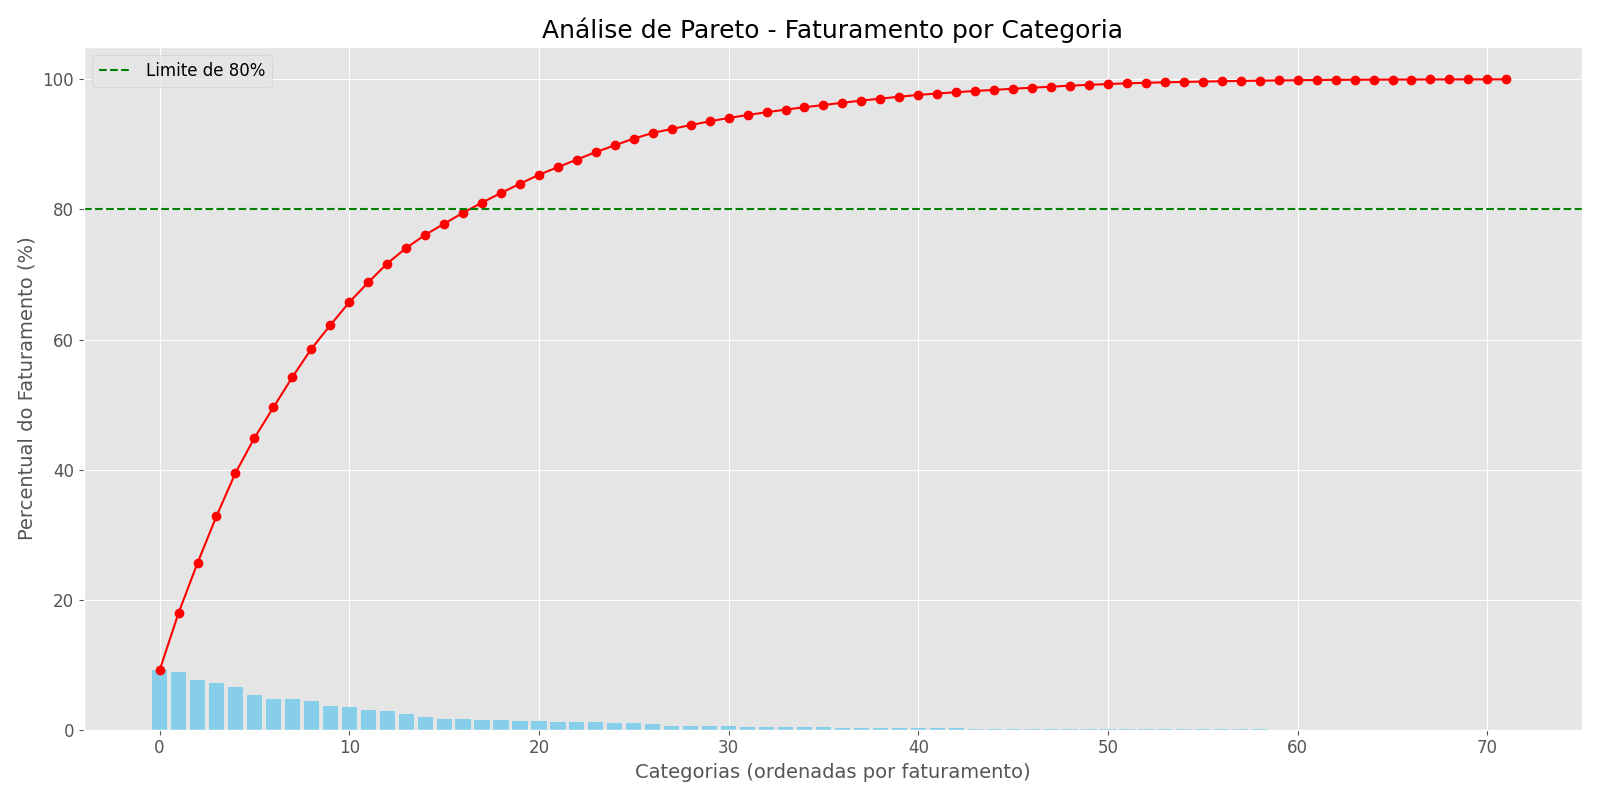


Número de categorias que representam 80% do faturamento: 17
Total de categorias: 72
Percentual de categorias que representam 80% do faturamento: 23.61%

============ E) Estados brasileiros com maior valor médio de pedido ============

Valor médio de pedido por estado brasileiro:
   estado  num_pedidos  faturamento_total  valor_medio_pedido
0      pb          532          123726.34          232.568308
1      ac           81           17059.44          210.610370
2      al          411           83110.36          202.214988
3      to          279           56251.91          201.619749
4      ap           68           13654.30          200.798529
5      rn          482           94554.55          196.171266
6      ro          247           46964.03          190.137773
7      pa          970          184407.88          190.111216
8      mt          903          170822.04          189.171694
9      pi          493           92167.70          186.952738
10     ce         1327          23941

C:\Users\Renan Oliveira\AppData\Local\Temp\ipykernel_15376\3936874403.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='valor_medio_pedido', y='estado', data=estados, palette='viridis')


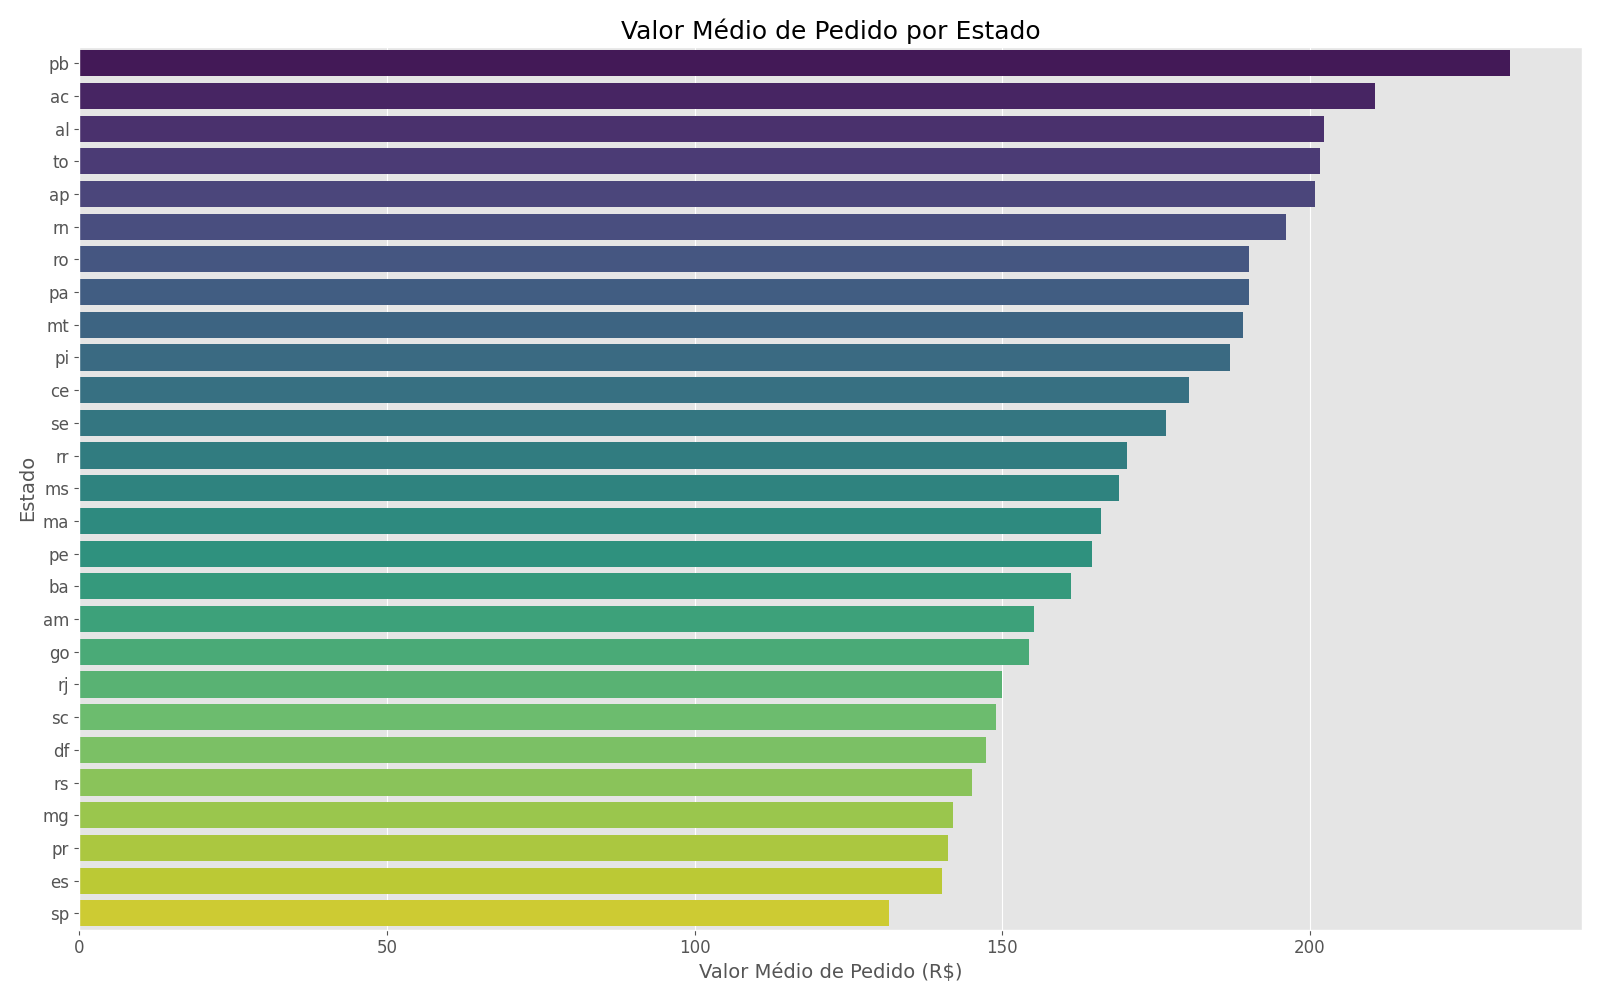

C:\Users\Renan Oliveira\AppData\Local\Temp\ipykernel_15376\3936874403.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='faturamento_total', y='estado', data=estados.sort_values('faturamento_total', ascending=False),


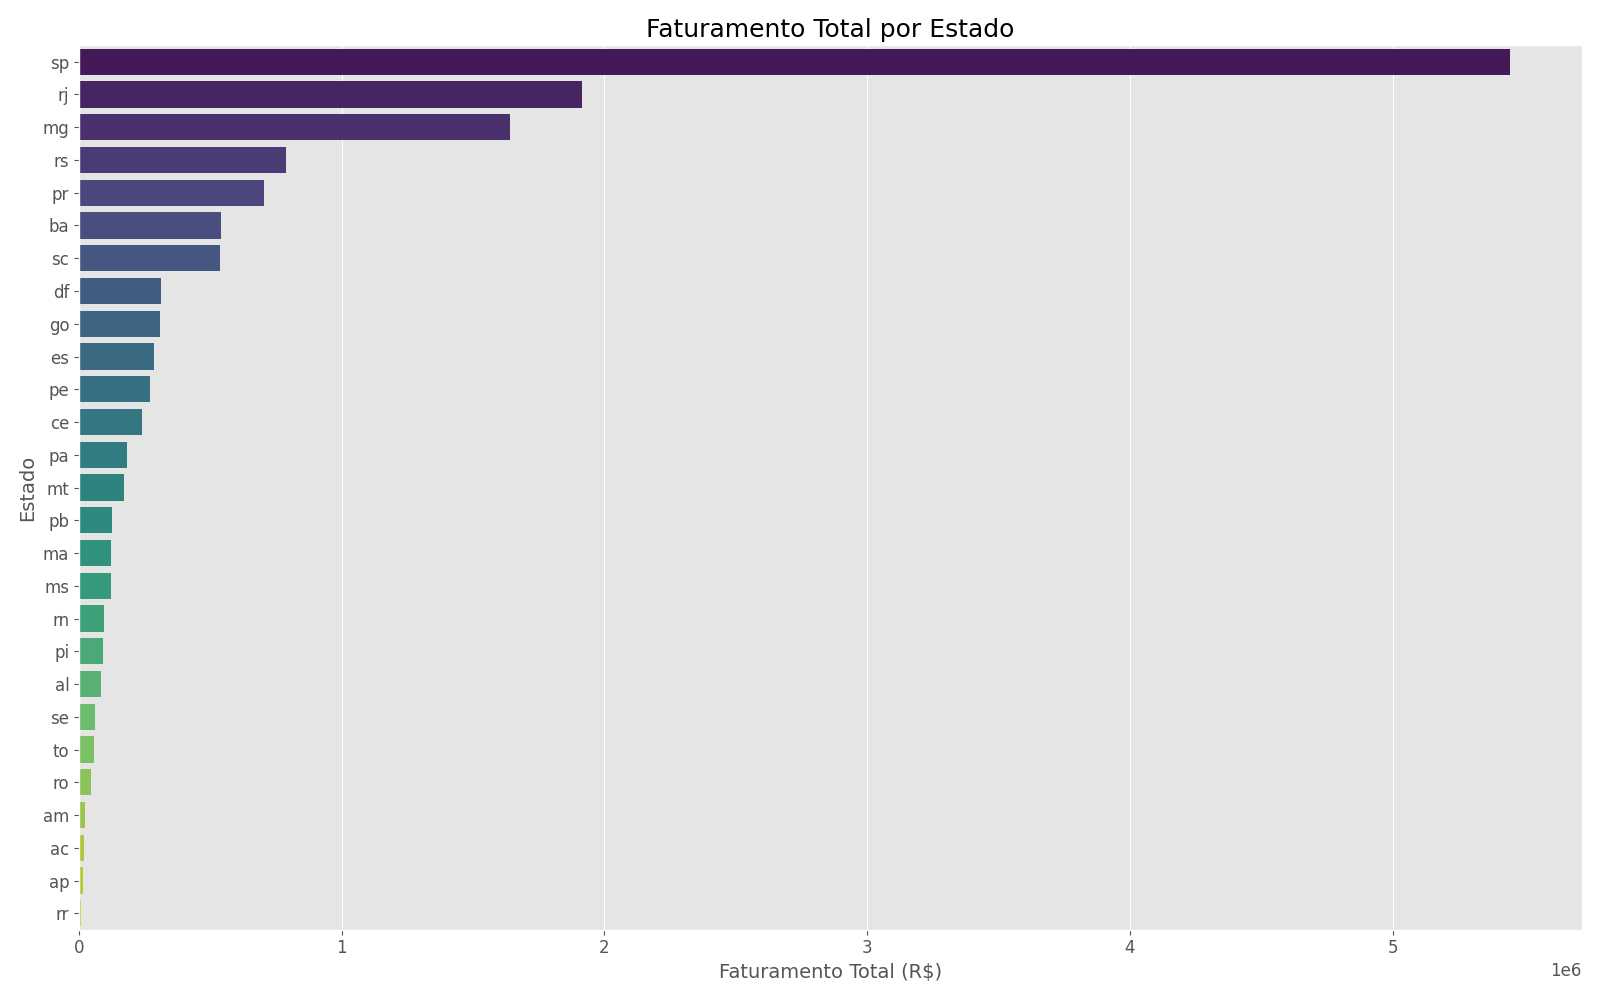

C:\Users\Renan Oliveira\AppData\Local\Temp\ipykernel_15376\3936874403.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_pedidos', y='estado', data=estados.sort_values('num_pedidos', ascending=False),


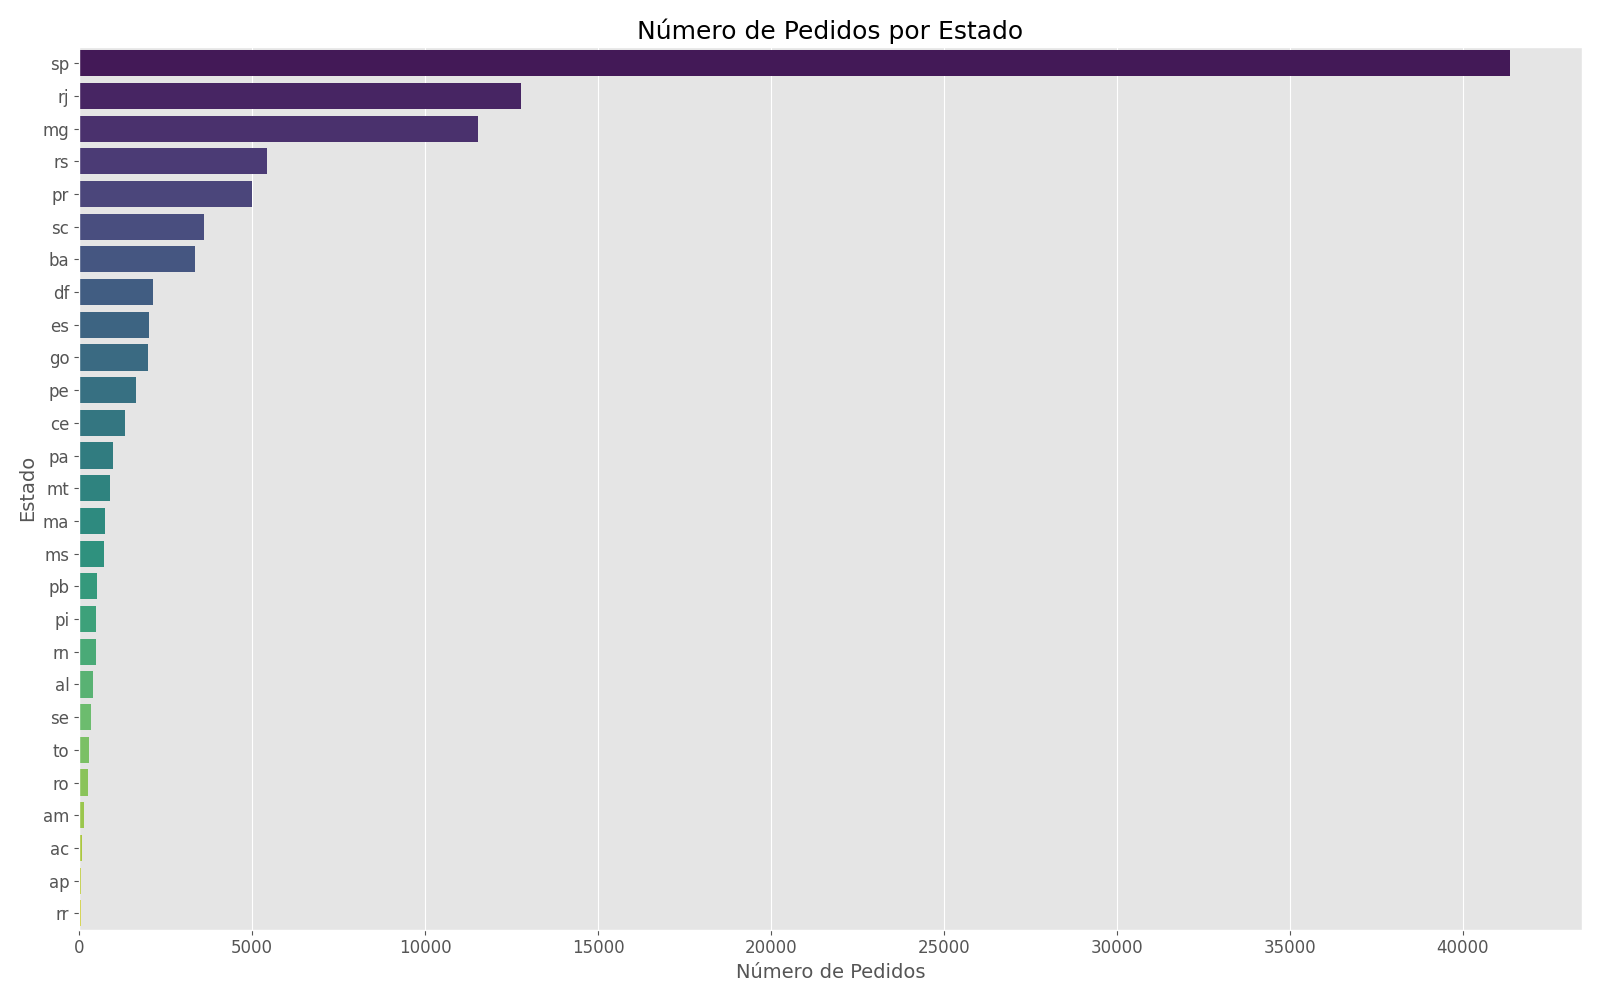

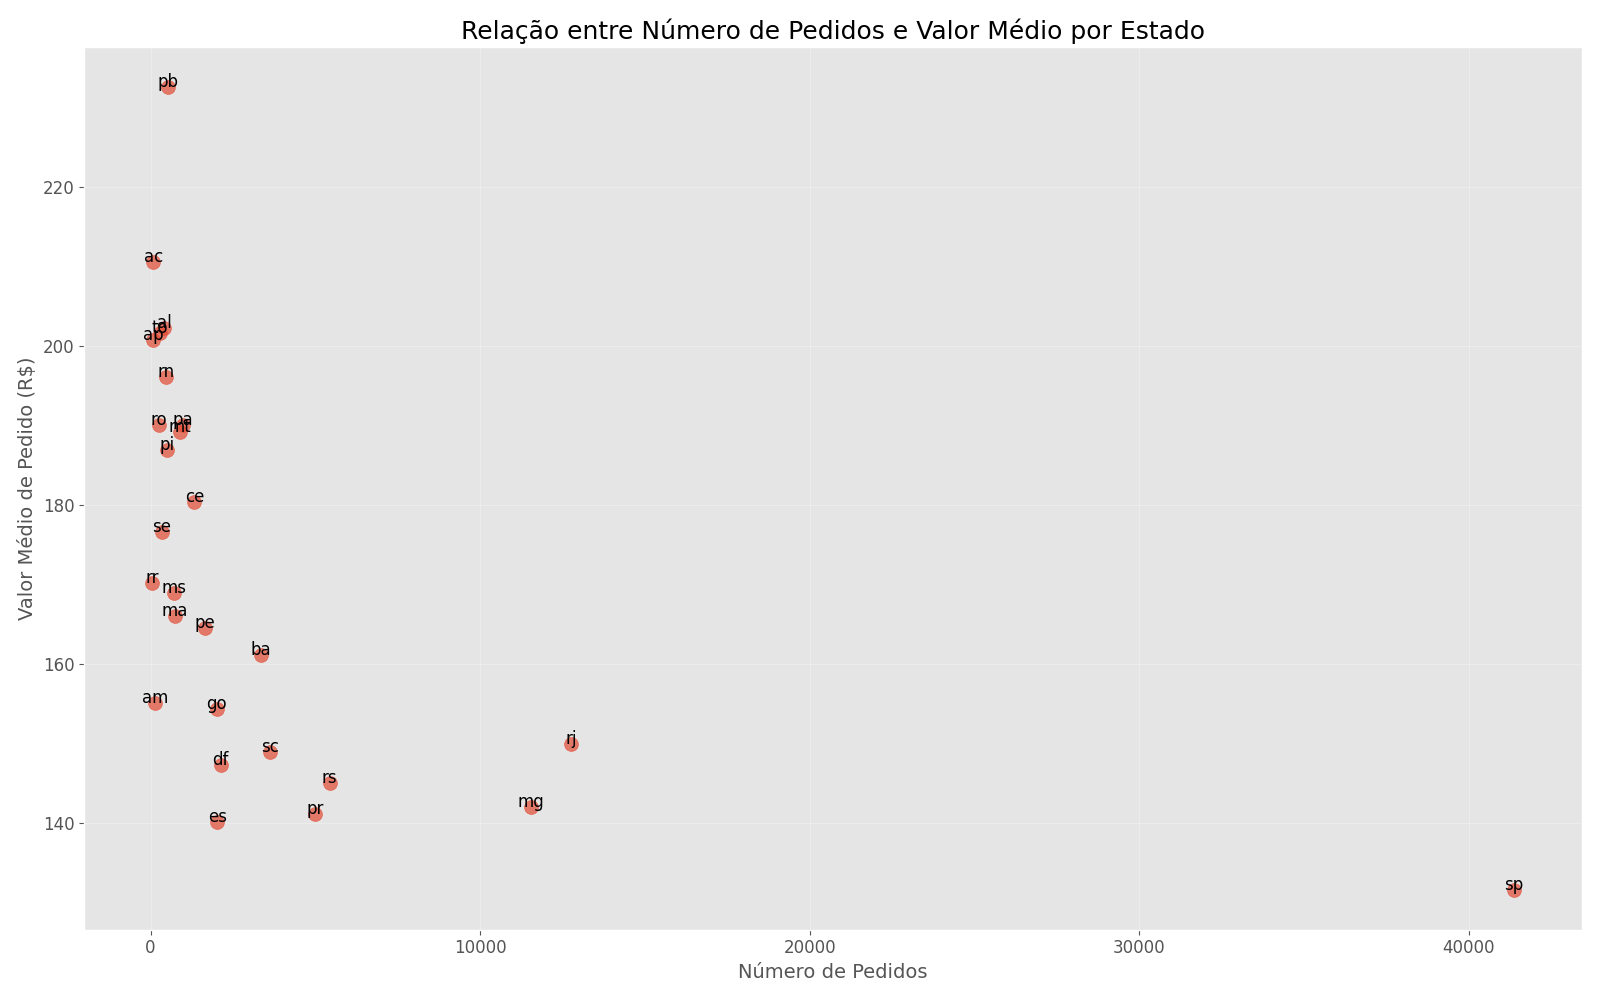


================== ANÁLISE EXPLORATÓRIA CONCLUÍDA COM SUCESSO ==================



In [20]:
def main():
    """Função principal para executar todas as análises."""
    try:
        print_section("ANÁLISE EXPLORATÓRIA DE DADOS - E-COMMERCE BRASILEIRO")
        
        conn = sqlite3.connect(GOLD_DB_PATH)
        
        vendas_mensais = analise_volume_pedidos(conn)
        tempo_entrega = analise_tempo_entrega(conn)
        dados_frete = analise_frete_distancia(conn)
        categorias = analise_categorias_produtos(conn)
        estados = analise_estados_valor_pedido(conn)
        
        conn.close()
        
        print_section("ANÁLISE EXPLORATÓRIA CONCLUÍDA COM SUCESSO")
        
    except Exception as e:
        print(f"Erro durante a análise: {str(e)}")

if __name__ == "__main__":
    main()